<a href="https://colab.research.google.com/github/araldi/HS21---Big-Data-Analysis-in-Biomedical-Research-376-1723-00L-/blob/main/Week6/LinearModels_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate linear regression



### Categorical variables

In the formulas, you can specify quantitative and categorical variables with the notation:


```
'y ~ C(name_cat_variable) + Q("name_quant_variable")'
```
(note the double use of " and ')

If you want to specify which one of the categorical variables is your reference variable (the one from which all the computations will be made), then specify it in the levels. The first level will be the reference.

```
'y ~ C(name_cat_variable, levels = [reference_category, category1, category2, category3, ...) + Q("name_quant_variable")'
```

Or you can use OneHotEncoding to transform categorical variables into individual columns.

```
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(df[['column_to_encode']])
one_hot = enc.transform(df[['column_to_encode']]).toarray()
df[enc.categories_] = one_hot
```




### Feature engineering
**Better features = more flexibility**


**Better features = better predictions**

How to do feature engineering? 

*   Transform data (for quantitative: transform into a new unit, logarithmic, power, etc, for categorical: subset of categories, family of categories)
*   Find relationships across variables (ratio/difference/power among features in the model, feature interactions (see below))



Within the linear model, you can define in the formula further interactions among predictor variables using the patsy notation in statsmodels.formula.api. Below there is the explanation of the formula symbols.

#### Formulas with patsy
**~**

Separates the left-hand side and right-hand side of a formula. Optional. If not present, then the formula is considered to contain a right-hand side only.


**+**  
Takes the set of terms given on the left and the set of terms given on the right, and returns a set of terms that combines both (i.e., it computes a set union). Note that this means that a + a is just a

**:**

This takes two sets of terms, and computes the interaction between each term on the left and each term on the right. So, for example, (a + b):(c + d) is the same as a:c + a:d + b:c + b:d. Calculating the interaction between two terms is also a kind of set union operation, but : takes the union of factors within two terms, while + takes the union of two sets of terms. Note that this means that a:a is just a, and (a:b):(a:c) is the same as a:b:c.

**\***  

a \* b is short-hand for a + b + a:b, and is useful for the common case of wanting to include all interactions between a set of variables while partitioning their variance between lower- and higher-order interactions. Standard ANOVA models are of the form a * b * c * ....



**/**

a / b is shorthand for a + a:b, and is intended to be useful in cases where you want to fit a standard sort of ANOVA model, but b is nested within a, so a*b doesn’t make sense. So far so good. Also, if you have multiple terms on the right, then the obvious thing happens: a / (b + c) is equivalent to a + a:b + a:c (/ is rightward distributive over +). But, if you have multiple terms on the left, then there is a surprising special case: (a + b)/c is equivalent to a + b + a:b:c (and note that this is different from what you’d get out of a/c + b/c – / is not leftward distributive over +). Again, this is motivated by the idea of using this for nested variables. It doesn’t make sense for c to be nested within both a and b separately, unless b is itself nested in a – but if that were true, then you’d write a/b/c instead. So if we see (a + b)/c, we decide that a and b must be independent factors, but that c is nested within each combination of levels of a and b, which is what a:b:c gives us. 

**\*\***

This takes a set of terms on the left, and an integer n on the right, and computes the * of that set of terms with itself n times. This is useful if you want to compute all interactions up to order n, but no further.

[link text](https://patsy.readthedocs.io/en/latest/formulas.html
)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Predict insurance charges

Explore the dataset and plot the most relevant parameters to find which predictor variables to use for the linear model.

In [ ]:
medical_charges_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'
medical_charges= pd.read_csv(medical_charges_url)

In [ ]:
medical_charges

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
medical_charges.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
# check if there are missing values
medical_charges.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Text(0, 0.5, 'Individuals [counts]')

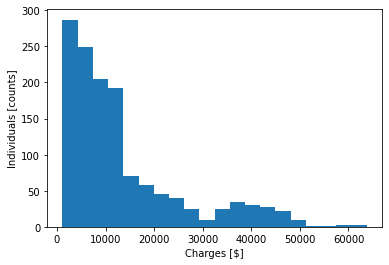

In [ ]:
plt.hist(medical_charges['charges'], bins =20)
plt.xlabel('Charges [$]')
plt.ylabel('Individuals [counts]')

### Exercise 1
 
Plot the relationship between charges and all the other features.
What is the covariance of all the features?

###  Exercise 2

Find a linear model that predicts the charges based on the parameters you have.

Which is the most important predictor?

Which is the least important predictor?

How much do charges change when a person is a smoker and has BMI >30?

How much does being in the north change the charges?

And what about being in the southwest?



In [ ]:
# don't forget to standardize the quantitative data!
def standardize(x):
  return (x-np.mean(x))/np.std(x)

### Exercise 3

Are there other interactions among features?

What if a separate linear regression for smokers and one for non-smokers is better than a one-size-fits all regression? Test it!